
# Objective:
---------
### Building a deep learning classifier capable of distinguishing between various chart types—including scatter plots, pie charts, line graphs, flowcharts, and bar graphs.


### 1. Imports and Setup
This section loads all required Python libraries used throughout the notebook, including:
- TensorFlow and Keras for deep learning
- OpenCV and PIL for image handling
- Scikit-learn for data splitting and metrics
- Matplotlib for plotting

In [ ]:
# --- Imports ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score as sk_f1_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


### 2. Dataset Configuration and Preparation
We define image dimensions, paths, and batch size, and collect all `.png` image paths from a directory structure like:

dataset_png/
├── bargraph/
├── flowchart/
├── linegraph/
├── piechart/
└── scatterplot/

Then, we split the dataset into training and validation sets using stratified sampling.


In [2]:
# --- Configuration ---
dataset_dir = 'dataset_png'  # contains subfolders for each class
img_height, img_width = 224, 224
batch_size = 32
epochs = 20

In [3]:
# --- Gather file paths and labels ---
classes = sorted(os.listdir(dataset_dir))
filepaths, labels = [], []
for cls in classes:
    cls_dir = os.path.join(dataset_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith('.png'):
            filepaths.append(os.path.join(cls_dir, fname))
            labels.append(cls)

data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# --- Split into train/validation ---
train_df, val_df = train_test_split(
    data, test_size=0.2, stratify=data['label'], random_state=42
)

### Data Generators for Training
We use Keras’ ImageDataGenerator to load and preprocess images in real-time with optional augmentation for the training set.


In [4]:
# --- Data Generators with Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    channel_shift_range=20.0,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', shuffle=True
)
val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(img_height, img_width), batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

Found 1901 validated image filenames belonging to 5 classes.
Found 476 validated image filenames belonging to 5 classes.


### 3. Define Custom F1 Score Metric
Keras doesn't include a macro F1 score by default, so we define our own using TensorFlow backend operations.


In [5]:
# --- F1 Metric Definition ---
def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

### 4. Build the Model Using MobileNetV2
We use MobileNetV2 as the base model (pretrained on ImageNet) and add custom classification layers on top. The base is frozen to retain learned features.


In [ ]:
# --- Build Model (Transfer Learning) ---
base = MobileNetV2(weights='imagenet', include_top=False,
                   input_shape=(img_height, img_width, 3))
base.trainable = False
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base.input, outputs=outputs)

### 5. Compile the Model
The model is compiled with:
- Adam optimizer
- Categorical crossentropy loss
- Accuracy and custom F1 score as metrics


In [ ]:
model.compile(
    optimizer='adam', loss='categorical_crossentropy',
    metrics=['accuracy', f1_metric]
)

: 

### 6. Callbacks: ModelCheckpoint and EarlyStopping
These help monitor validation metrics and stop training early if no improvement is seen to avoid overfitting.


In [7]:
# --- Callbacks ---
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

### 7. Train the Model
We train the model using the training generator and evaluate it on the validation generator over multiple epochs.


In [8]:
# --- Train ---
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/20
60/60 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.8401 - f1_metric: 0.7944
Epoch 1: val_f1_metric improved from inf to 0.94626, saving model to best_model.h5
60/60 [==============================] - 51s 811ms/step - loss: 0.4564 - accuracy: 0.8401 - f1_metric: 0.7944 - val_loss: 0.1495 - val_accuracy: 0.9517 - val_f1_metric: 0.9463
Epoch 2/20
60/60 [==============================] - ETA: 0s - loss: 0.1961 - accuracy: 0.9369 - f1_metric: 0.9231
Epoch 2: val_f1_metric improved from 0.94626 to 0.94313, saving model to best_model.h5
60/60 [==============================] - 52s 867ms/step - loss: 0.1961 - accuracy: 0.9369 - f1_metric: 0.9231 - val_loss: 0.1551 - val_accuracy: 0.9517 - val_f1_metric: 0.9431
Epoch 3/20
60/60 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 0.9484 - f1_metric: 0.9344
Epoch 3: val_f1_metric did not improve from 0.94313
60/60 [==============================] - 49s 806ms/step - loss: 0.1602 - accuracy: 0

### 8. Evaluate the Model
After training, we evaluate the saved best model on the validation set and display accuracy and F1 score.

We also generate a confusion matrix to visualize class-wise performance and print a detailed classification report.


15/15 [==============================] - 8s 517ms/step - loss: 0.1415 - accuracy: 0.9538 - f1_metric: 0.9474
Validation accuracy: 0.95
Validation F1 (macro): 0.95
15/15 [==============================] - 9s 524ms/step


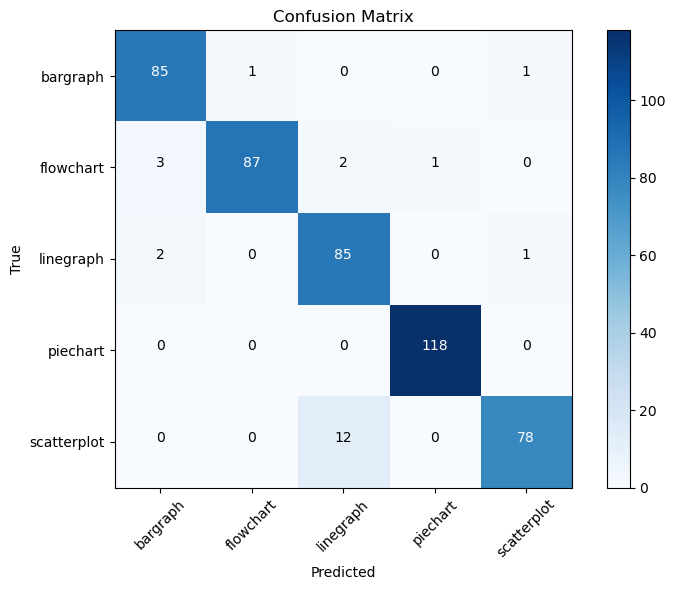

              precision    recall  f1-score   support

    bargraph       0.94      0.98      0.96        87
   flowchart       0.99      0.94      0.96        93
   linegraph       0.86      0.97      0.91        88
    piechart       0.99      1.00      1.00       118
 scatterplot       0.97      0.87      0.92        90

    accuracy                           0.95       476
   macro avg       0.95      0.95      0.95       476
weighted avg       0.95      0.95      0.95       476

sklearn F1 (macro): 0.95


In [9]:
# --- Evaluate ---
loss, acc, f1 = model.evaluate(val_gen)
print(f"Validation accuracy: {acc:.2f}")
print(f"Validation F1 (macro): {f1:.2f}")

# --- Error Analysis ---
best_model = load_model('best_model.h5', custom_objects={'f1_metric': f1_metric})
val_gen.reset()
y_prob = best_model.predict(val_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = val_gen.classes
class_labels = list(train_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))

plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

ticks = np.arange(len(class_labels))
plt.xticks(ticks, class_labels, rotation=45)
plt.yticks(ticks, class_labels)
threshold = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], ha='center',
             color='white' if cm[i, j] > threshold else 'black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))
print(f"sklearn F1 (macro): {sk_f1_score(y_true, y_pred, average='macro'):.2f}")

### 9. Visualize Misclassified Samples
We identify incorrect predictions and display a few sample images along with their true and predicted labels.

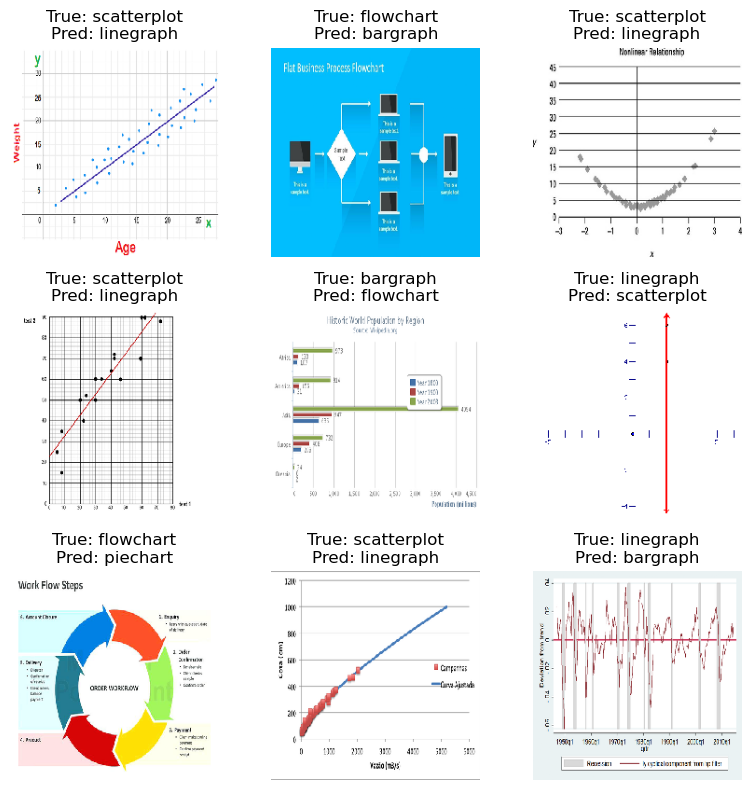

In [41]:
# --- Sanity check: Visualize a few misclassifications ---
errors = np.where(y_pred != y_true)[0]
if errors.size:
    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(errors[:9]):
        img = load_img(val_df.iloc[idx]['filepath'], target_size=(img_height, img_width))
        arr = img_to_array(img) / 255.0
        plt.subplot(3, 3, i + 1)
        plt.imshow(arr)
        plt.title(f"True: {val_df.iloc[idx]['label']}\nPred: {class_labels[y_pred[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples.")


### 10. Predict a Single Image
We define a function to predict the label of a single image and display it along with confidence.

To understand what part of an image the model focused on, we generate a Grad-CAM heatmap overlayed on the image.

1/1 [==============================] - 0s 46ms/step


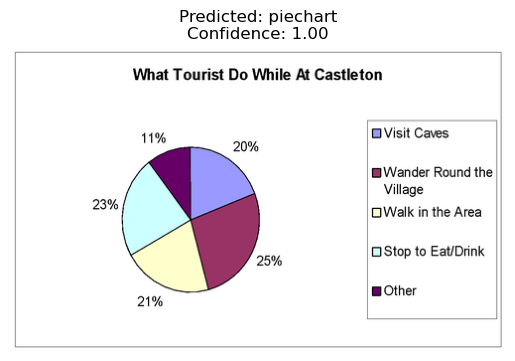

Predicted Label: piechart, Confidence: 1.00


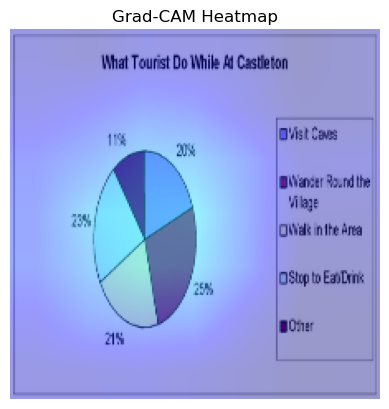

In [40]:
# --- Inference on a Single Image ---
def predict_image(image_path, model, class_labels):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)[0]
    confidence = np.max(pred)

    plt.imshow(load_img(image_path))
    plt.title(f"Predicted: {class_labels[pred_class]}\nConfidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()

    return class_labels[pred_class], confidence

# Predict one random image
sample_image_path = val_df.sample(1).iloc[0]['filepath']
predicted_label, conf = predict_image(sample_image_path, best_model, class_labels)
print(f"Predicted Label: {predicted_label}, Confidence: {conf:.2f}")

# --- Grad-CAM Heatmap ---
def find_last_conv_layer(model):
    # Find the last Conv2D layer in the model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)[0]
    conv_outputs = conv_outputs[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs *= pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)

    heatmap = np.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_width, img_height))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# Apply Grad-CAM
last_conv_layer_name = find_last_conv_layer(best_model)

img = load_img(sample_image_path, target_size=(img_height, img_width))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)
display_gradcam(sample_image_path, heatmap)
